# Artificial Neural Network

An Artificial Neural Network (ANN) is one of the core techniques in deep learning, inspired by the structure and function of the human brain. It consists of layers of interconnected nodes, or "neurons," which process input data and learn patterns through weighted connections.

The network is trained by adjusting these weights in response to the errors made during prediction, allowing the model to improve its accuracy over time.

# Setup Environment

In [32]:
import gdown
import zipfile
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


#Fetch the dataset from google drive
file_url = "https://drive.google.com/uc?id=12MfYQpBl_79ak9K7VHx4jDEaeFUEhHEO"
output_zip = "spam.zip"
gdown.download(file_url, output_zip, quiet=False)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall("spam_files")
os.remove(output_zip)

Downloading...
From: https://drive.google.com/uc?id=12MfYQpBl_79ak9K7VHx4jDEaeFUEhHEO
To: /content/spam.zip
100%|██████████| 3.58M/3.58M [00:00<00:00, 94.4MB/s]


In [33]:
#read the dataset
df = pd.read_csv('/content/spam_files/url_spam_classification.csv')


# Data Preprocessing

The ANN can only accept the numerical data as input, however the spam URL dataset values are in string format so the value have to first convert into binary format.

In [34]:
# dataframe sample
print("Print Sample Data Frame")
print(df.head(5))

# converting to binary
df['is_spam'] = df['is_spam'].apply(lambda x: 1 if x == df['is_spam'].unique()[0] else 0)
df['is_spam'].unique()

Print Sample Data Frame
                                                 url  is_spam
0  https://briefingday.us8.list-manage.com/unsubs...     True
1                             https://www.hvper.com/     True
2                 https://briefingday.com/m/v4n3i4f3     True
3   https://briefingday.com/n/20200618/m#commentform    False
4                        https://briefingday.com/fan     True


array([1, 0])

Data record distribution Visualization.

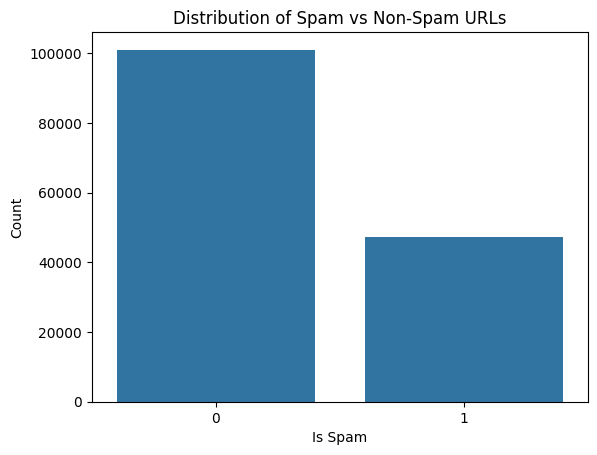

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the distribution of 'is_spam' column
spam_distribution = df['is_spam'].value_counts()

# Plotting the distribution using seaborn
sns.barplot(x=spam_distribution.index, y=spam_distribution.values)

# Adding labels and title
plt.title('Distribution of Spam vs Non-Spam URLs')
plt.xlabel('Is Spam')
plt.ylabel('Count')

# Display the plot
plt.show()

Vectorize the Dataset using TFIDF Vectorizer



In [36]:

vectorizer = TfidfVectorizer(max_features=50000, ngram_range=(1, 2), lowercase=True, stop_words='english')
X = vectorizer.fit_transform(df['url'])


Data folds (20% for testing, 80% for training)

In [37]:
y = df['is_spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.astype(int).reset_index(drop=True)
y_test = y_test.astype(int).reset_index(drop=True)


# Model Architecture 4 Layer Model (Input + 2 Hidden + 1 Output)

In [38]:

# ANN model with increased regularization
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.7),
    Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(32, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

# Model Summary Display
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │       6,400,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,410,497 (24.45 MB)

 Trainable params: 6,410,497 (24.45 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
#optimize the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

# weight distribution
class_weight = {0: 1.0, 1: 1.0}


# Model Training

In [40]:
history = model.fit(
    X_train, y_train, epochs=10, batch_size=16,
    validation_data=(X_test, y_test),
    class_weight=class_weight, callbacks=[early_stopping, reduce_lr]
)



Epoch 1/10
7416/7416 ━━━━━━━━━━━━━━━━━━━━ 428s 57ms/step - accuracy: 0.6458 - loss: 0.6701 - val_accuracy: 0.6832 - val_loss: 0.5724 - learning_rate: 1.0000e-05
Epoch 2/10
7416/7416 ━━━━━━━━━━━━━━━━━━━━ 427s 58ms/step - accuracy: 0.6789 - loss: 0.5624 - val_accuracy: 0.6832 - val_loss: 0.4409 - learning_rate: 1.0000e-05
Epoch 3/10
7416/7416 ━━━━━━━━━━━━━━━━━━━━ 445s 58ms/step - accuracy: 0.7014 - loss: 0.4607 - val_accuracy: 0.8954 - val_loss: 0.3502 - learning_rate: 1.0000e-05
Epoch 4/10
7416/7416 ━━━━━━━━━━━━━━━━━━━━ 425s 57ms/step - accuracy: 0.8386 - loss: 0.3770 - val_accuracy: 0.9301 - val_loss: 0.2835 - learning_rate: 1.0000e-05
Epoch 5/10
7416/7416 ━━━━━━━━━━━━━━━━━━━━ 445s 58ms/step - accuracy: 0.9156 - loss: 0.3117 - val_accuracy: 0.9443 - val_loss: 0.2170 - learning_rate: 1.0000e-05
Epoch 6/10
7416/7416 ━━━━━━━━━━━━━━━━━━━━ 440s 58ms/step - accuracy: 0.9349 - loss: 0.2503 - val_accuracy: 0.9541 - val_loss: 0.1683 - learning_rate: 1.0000e-05
Epoch 7/10
7416/7416 ━━━━━━━━━━━━━

# Training Outcome

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred = (model.predict(X_test) > 0.7).astype(int)


unique_classes = np.unique(y_test)

#Classification Report Generation
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[f'Class {label}' for label in unique_classes]))



927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9652 - loss: 0.1120
Test Accuracy: 0.9669
Test Loss: 0.1073
927/927 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.99      0.97     20263
     Class 1       0.97      0.91      0.94      9398

    accuracy                           0.96     29661
   macro avg       0.97      0.95      0.96     29661
weighted avg       0.96      0.96      0.96     29661



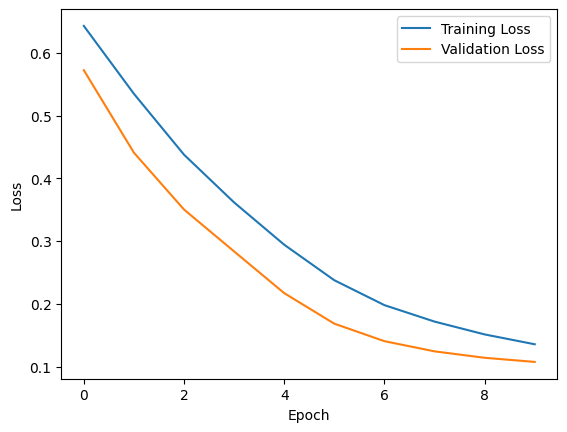

In [42]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

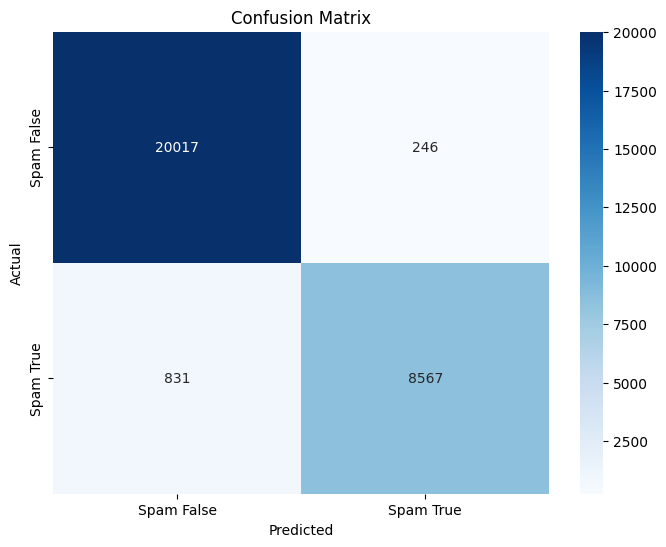

In [43]:
#confusion metrics
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Spam False', 'Spam True'], yticklabels=['Spam False', 'Spam True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Validation on Training Dataset

In [44]:


df_test = pd.DataFrame({
    'Link': [
        'https://briefingday.us8.list-manage.com/unsubs',
        'https://numlock.substack.com/subscribe',
        'https://briefingday.com/n/20200618/m#commentform',
        'https://www.youtube.com/',
        'https://www.google.com/',
        'https://hitha.substack.com/people/976632-hitha-palepu',
        'https://us3.campaign-archive.com/',
        'https://cdn.substack.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2Fcd5914a8-e144-4812-8e41-67e295f05007_150x25.png',
        'http://tib.matthewclifford.com/issues/tib-131-how-smart-are-politicians-why-tech-needs-some-crazy-money-religious-fundamentalism-and-the-internet-and-more-276446',
        'https://web.whatsapp.com/',
        'https://outlook.office365.com/'
    ],
    'Label': [1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0]
})


# change the threshold and experience
X_test_new = vectorizer.transform(df_test['Link'])
predictions = (model.predict(X_test_new) > 0.6).astype(int)


df_test['Predicted'] = predictions
df_test['Prediction Probability'] = model.predict(X_test_new)



print("\nPrediction Results on New Data:")
print(df_test[['Link', 'Label', 'Predicted', 'Prediction Probability']])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Prediction Results on New Data:
                                                 Link  Label  Predicted  \
0      https://briefingday.us8.list-manage.com/unsubs      1          1   
1              https://numlock.substack.com/subscribe      1          1   
2    https://briefingday.com/n/20200618/m#commentform      0          0   
3                            https://www.youtube.com/      0          0   
4                             https://www.google.com/      0          0   
5   https://hitha.substack.com/people/976632-hitha...      1          1   
6                   https://us3.campaign-archive.com/      1          1   
7   https://cdn.substack.com/image/fetch/f_auto,q_...      1          1   
8   http://tib.matthewclifford.com/issues/tib-131-...      1          1   
9                           https://web.whatsapp.com/      0          0   
10                     https://outlook.office365.com/      0      

In [45]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# # Use y_pred instead of pred
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred)

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1-Score: {f1}")
# print(f"ROC AUC: {roc_auc}")


# Save the weight and load the model

In [46]:
# import joblib

# # Save the model and vectorizer
# joblib.dump(model, 'model.pkl')
# joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')


['tfidf_vectorizer.joblib']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')




vectorizer_path = '/content/drive/DeepLearningAssigment/MyDrive/tfidf_vectorizer.joblib'  # Update with your file path
model_path = '/content/drive/DeepLearningAssigment/MyDrive/model.pkl'  # Update with your file path

In [47]:

# Load the model and vectorizer using joblib.load
vectorizer = joblib.load('tfidf_vectorizer.joblib')  # Changed from load to joblib.load
loaded_model = joblib.load('model.pkl')

viva_test= pd.DataFrame({
    'Link': [
        'https://briefingday.us8.list-manage.com/unsubs',
        'https://numlock.substack.com/subscribe',
        'https://briefingday.com/n/20200618/m#commentform',
        'https://www.youtube.com/',
        'https://www.google.com/',
        'https://hitha.substack.com/people/976632-hitha-palepu',
        'https://us3.campaign-archive.com/',
        'https://cdn.substack.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2Fcd5914a8-e144-4812-8e41-67e295f05007_150x25.png',
        'http://tib.matthewclifford.com/issues/tib-131-how-smart-are-politicians-why-tech-needs-some-crazy-money-religious-fundamentalism-and-the-internet-and-more-276446',
        'https://web.whatsapp.com/',
        'https://outlook.office365.com/'
    ],
    'Label': [1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0]
})

X_Viva = vectorizer.transform(viva_test['Link'])

predictions = (loaded_model.predict(X_Viva) > 0.6).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
